# Import Libararies

In [1]:
# standard library
import math
import warnings

# scientific / data 
import numpy as np
import pandas as pd

# visualization (pick one main)
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from matplotlib.lines import Line2D

# sklearn / modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, cohen_kappa_score

# xgboost
from xgboost import XGBClassifier

# misc
warnings.filterwarnings("ignore")

# Dataset Loading

In [2]:
train_df = pd.read_csv('../data/raw/train.csv')
data_dictionary = pd.read_csv('../data/raw/data_dictionary.csv')

In [3]:
print(train_df.shape)
train_df.head(5)

(3960, 82)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train_df.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

In [5]:
print(data_dictionary.shape)
data_dictionary.head(5)

(81, 6)


,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


# Exploratory Data Analysis

## Understanding the Distribution of the Target Variable (sii) 

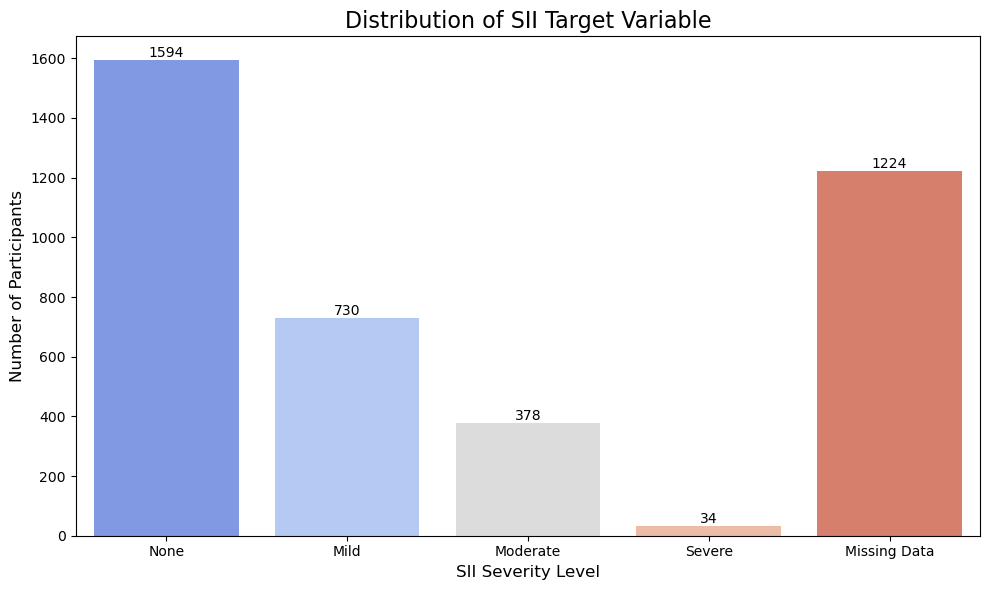

In [6]:
# Ensure the missing category is included
train_df['sii_category'] = train_df['sii'].fillna('Missing')

# Map `sii` categories to readable labels
label_mapping = {0: 'None', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 'Missing': 'Missing Data'}
train_df['sii_category'] = train_df['sii_category'].replace(label_mapping)

# Set the order for the categories
category_order = ['None', 'Mild', 'Moderate', 'Severe', 'Missing Data']

# Plot
plt.figure(figsize=(10, 6)) 
ax = sns.countplot(
    x='sii_category',
    data=train_df,
    order=category_order,
    palette='coolwarm'
)

# Add count annotations using enumerate and .text
for i, count in enumerate(train_df['sii_category'].value_counts().reindex(category_order)):
    ax.text(i, count + 10, str(count), ha='center', fontsize=10, color='black')

# Add titles and labels
plt.title('Distribution of SII Target Variable', fontsize=16)
plt.xlabel('SII Severity Level', fontsize=12)
plt.ylabel('Number of Participants', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

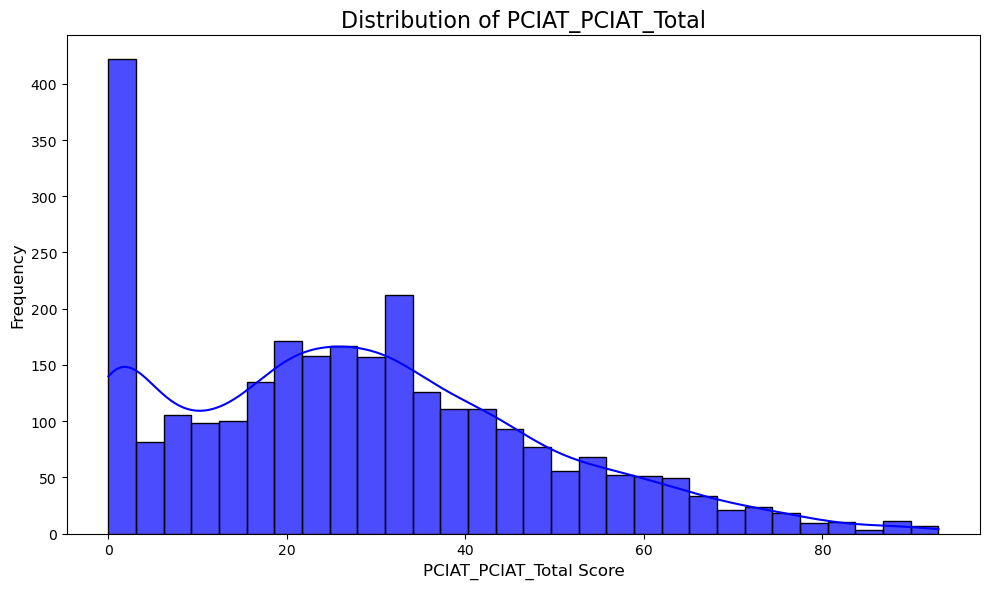

In [7]:
# Drop missing values for PCIAT_PCIAT_Total
pciat_total = train_df['PCIAT-PCIAT_Total'].dropna()

# Plot the distribution
plt.figure(figsize=(10, 6)) 
sns.histplot(pciat_total, bins=30, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of PCIAT_PCIAT_Total', fontsize=16)
plt.xlabel('PCIAT_PCIAT_Total Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## Gender Distribution

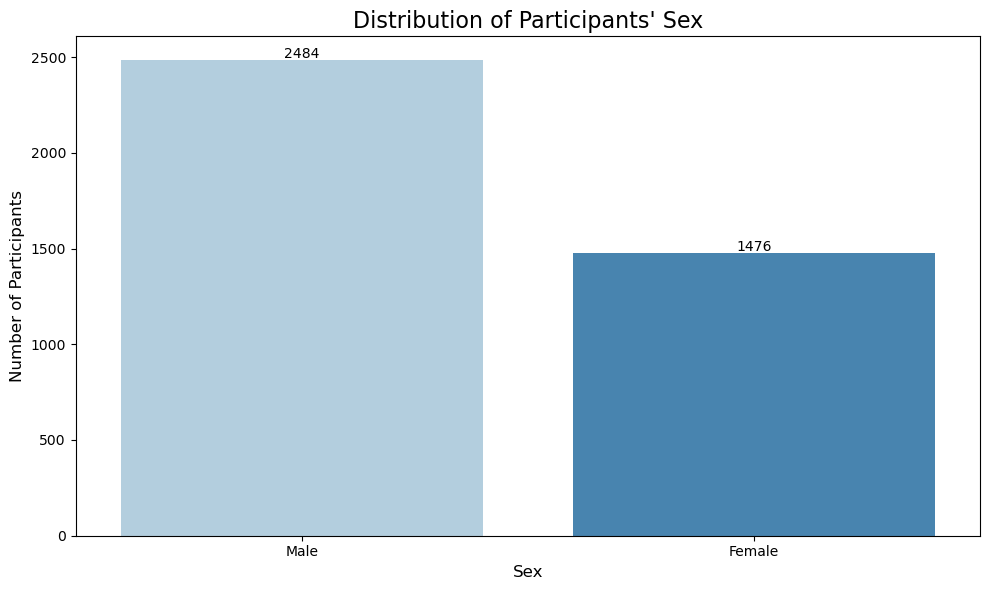

In [8]:
# Map the gender values to readable labels
gender_mapping = {0: 'Male', 1: 'Female'}
train_df['Basic_Demos-Sex'] = train_df['Basic_Demos-Sex'].replace(gender_mapping)

# Plot gender distribution
plt.figure(figsize=(10, 6))  # Set figure size
sns.countplot(x='Basic_Demos-Sex', data=train_df, palette='Blues')

# Add count annotations
gender_counts = train_df['Basic_Demos-Sex'].value_counts()
for i, count in enumerate(gender_counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=10, color='black')

# Add titles and labels
plt.title("Distribution of Participants' Sex", fontsize=16)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Number of Participants', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

## Age Distribution

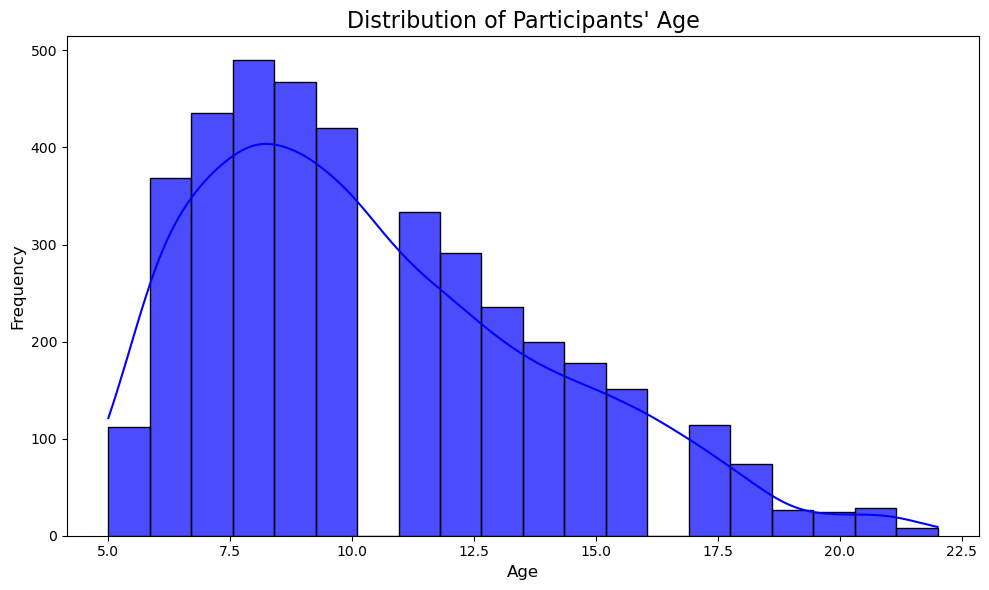

In [9]:
# Plot age distribution as a histogram
plt.figure(figsize=(10, 6)) 
sns.histplot(train_df['Basic_Demos-Age'], bins=20, kde=True, color='blue', alpha=0.7)

# Add titles and labels
plt.title('Distribution of Participants\' Age', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

## Internet Usage Distribution

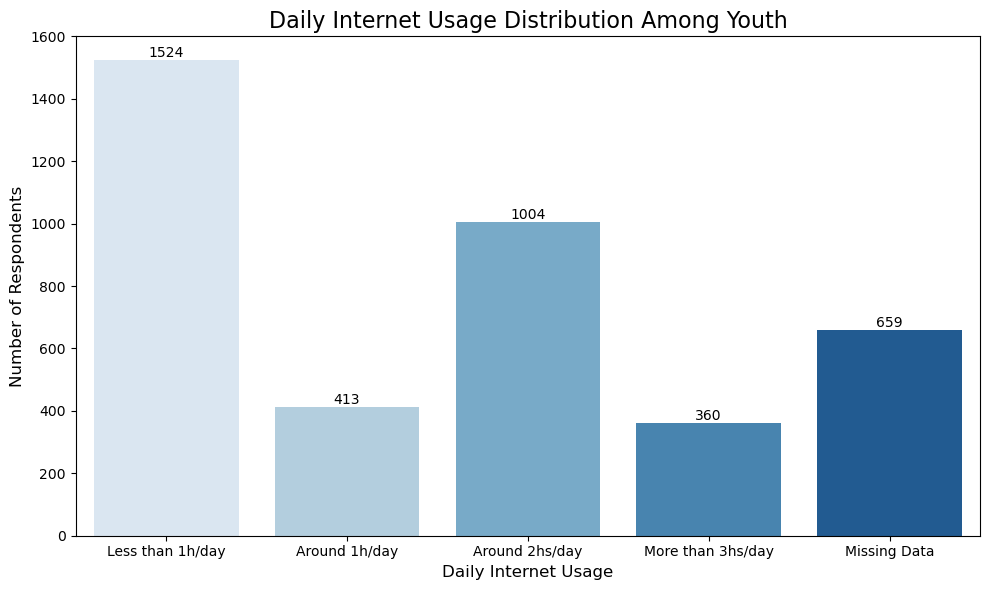

In [10]:
# Map numerical values to descriptive categories
usage_mapping = {
    0.0: 'Less than 1h/day',
    1.0: 'Around 1h/day',
    2.0: 'Around 2hs/day',
    3.0: 'More than 3hs/day'
}
train_df['internet_usage_category'] = train_df['PreInt_EduHx-computerinternet_hoursday'].map(usage_mapping)
train_df['internet_usage_category'] = train_df['internet_usage_category'].fillna('Missing Data')

# Plot the distribution
plt.figure(figsize=(10, 6))  # Adjust the figure size
ax = sns.countplot(
    x='internet_usage_category',
    data=train_df,
    order=['Less than 1h/day', 'Around 1h/day', 'Around 2hs/day', 'More than 3hs/day', 'Missing Data'],
    palette='Blues'
)

# Add count annotations
usage_counts = train_df['internet_usage_category'].value_counts()
for i, count in enumerate(usage_counts.reindex(['Less than 1h/day', 'Around 1h/day', 'Around 2hs/day', 'More than 3hs/day', 'Missing Data'])):
    ax.text(i, count + 10, str(count), ha='center', fontsize=10, color='black')

# Add titles and labels
plt.title('Daily Internet Usage Distribution Among Youth', fontsize=16)
plt.xlabel('Daily Internet Usage', fontsize=12)
plt.ylabel('Number of Respondents', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

## Physical Measures Distribution

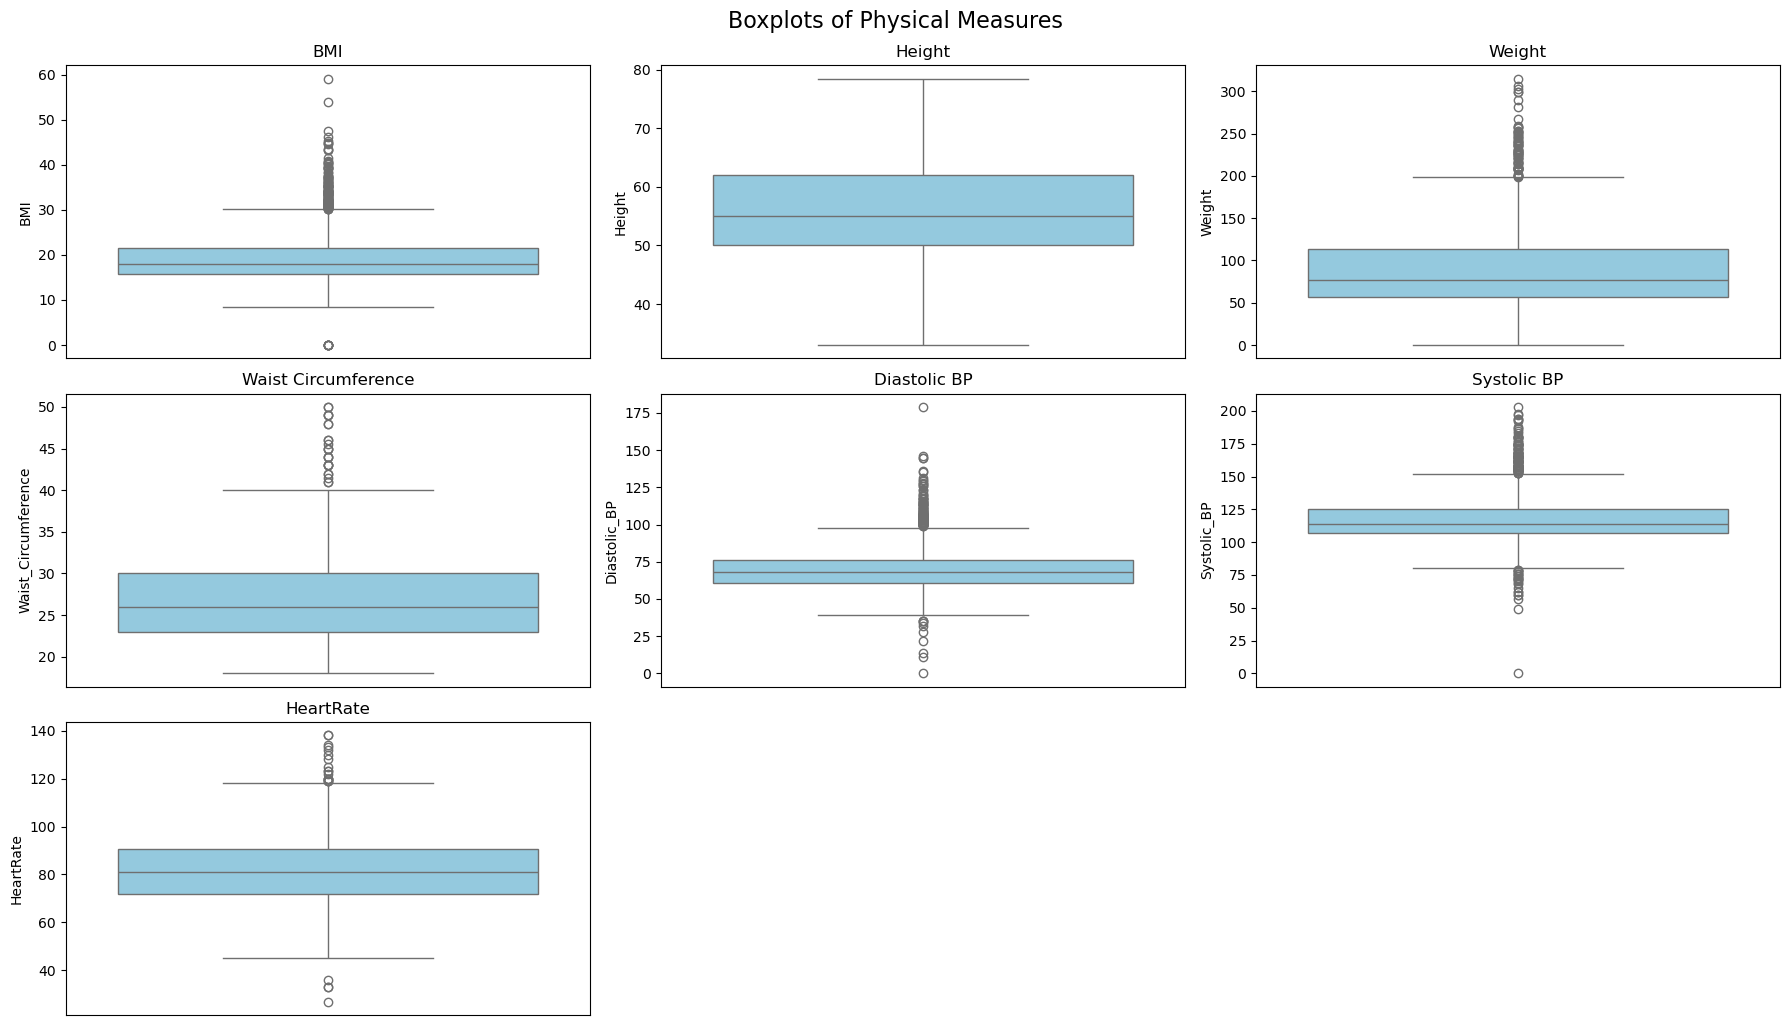

In [11]:
# List of physical measures
physical_cols = [
    'Physical-BMI', 'Physical-Height', 'Physical-Weight',
    'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
    'Physical-Systolic_BP', 'Physical-HeartRate'
]

# Set up the grid layout
n_cols = 3  # Number of columns
n_rows = -(-len(physical_cols) // n_cols)  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))  # Adjust figure size
axes = axes.flatten()

# Plot boxplots for each physical measure
for idx, col in enumerate(physical_cols):
    sns.boxplot(y=train_df[col], ax=axes[idx], color='skyblue')
    axes[idx].set_title(col.replace('Physical-', '').replace('_', ' '), fontsize=12)
    axes[idx].set_ylabel(col.split('-')[-1], fontsize=10)
    axes[idx].tick_params(axis='x', bottom=False, labelbottom=False)  # Hide x-axis ticks

# Remove extra subplots (if any)
for ax in axes[len(physical_cols):]:
    fig.delaxes(ax)

# Adjust layout
plt.tight_layout()
plt.suptitle("Boxplots of Physical Measures", fontsize=16, y=1.02)
plt.show()

## FitnessGram Vitals and Treadmill Distribution

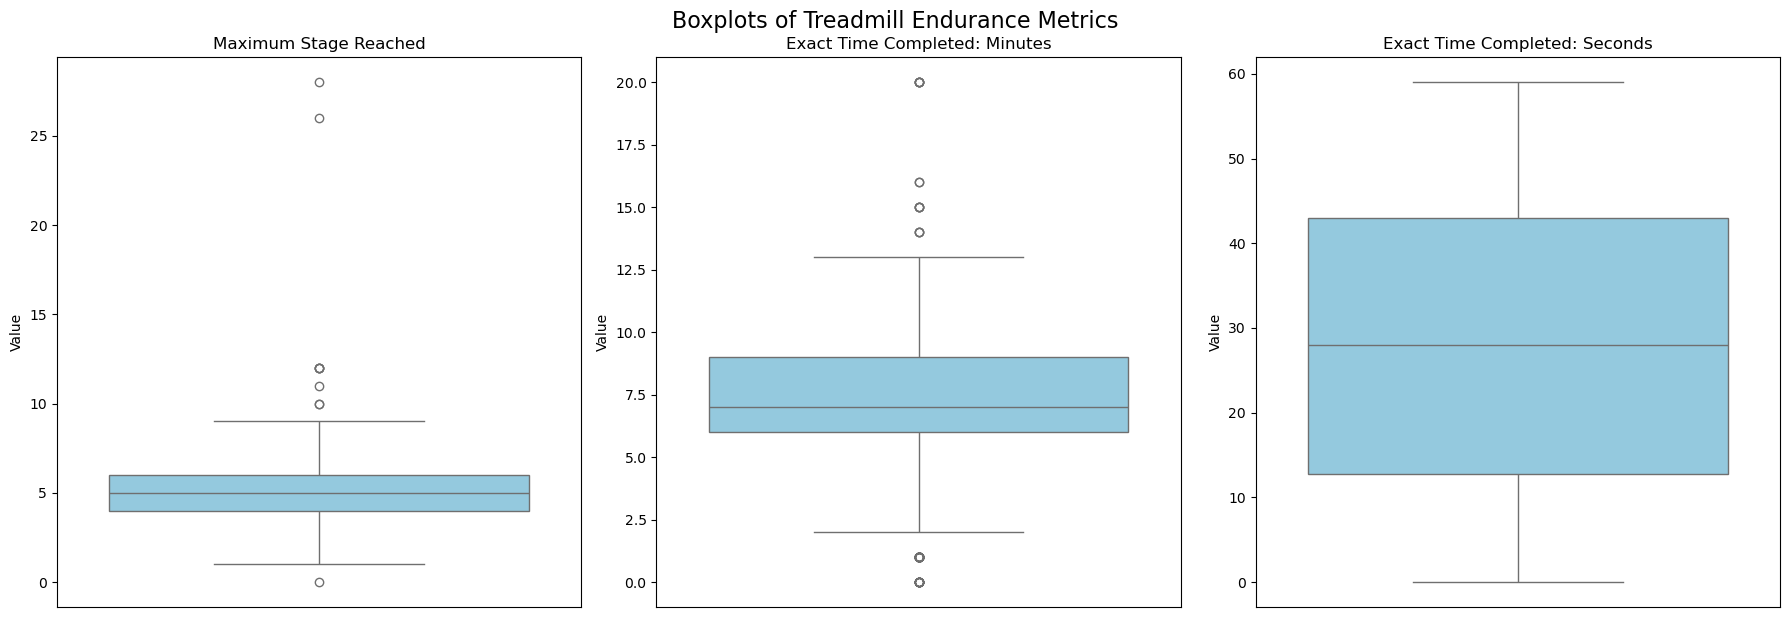

In [12]:
# List of treadmill variables with descriptive titles
treadmill_cols = [
    ('Fitness_Endurance-Max_Stage', 'Maximum Stage Reached'),
    ('Fitness_Endurance-Time_Mins', 'Exact Time Completed: Minutes'),
    ('Fitness_Endurance-Time_Sec', 'Exact Time Completed: Seconds')
]

# Set up the grid layout for boxplots
fig, axes = plt.subplots(1, len(treadmill_cols), figsize=(18, 6))  # One row for all boxplots

# Plot each variable
for idx, (col, title) in enumerate(treadmill_cols):
    sns.boxplot(y=train_df[col], ax=axes[idx], color='skyblue')
    axes[idx].set_title(title, fontsize=12)  # Use the descriptive title
    axes[idx].set_ylabel('Value', fontsize=10)
    axes[idx].tick_params(axis='x', bottom=False, labelbottom=False)  # Hide x-axis ticks

# Adjust layout
plt.tight_layout()
plt.suptitle('Boxplots of Treadmill Endurance Metrics', fontsize=16, y=1.02)
plt.show()

## FitnessGram Child Distribution

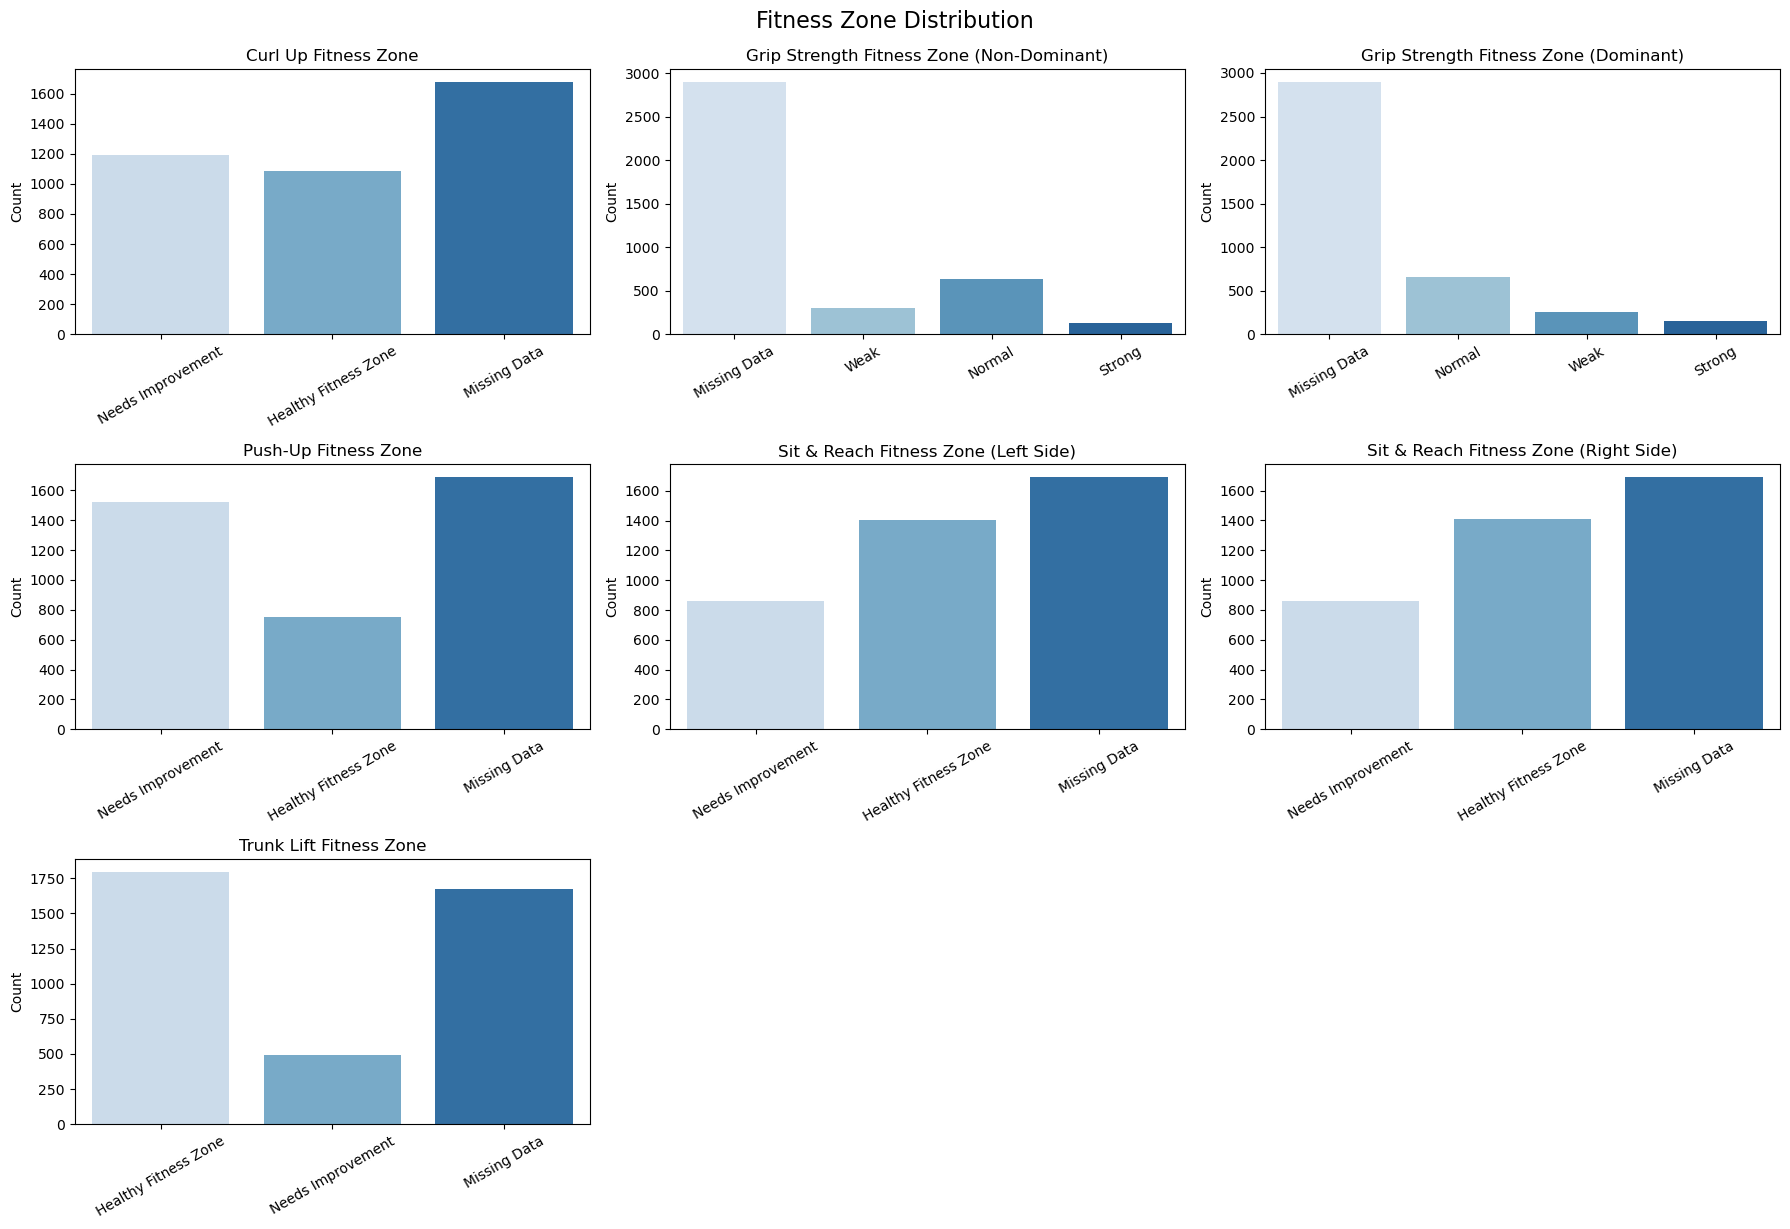

In [13]:
# Define mappings for categorical zones
zone_mapping_binary = {
    0: "Needs Improvement",
    1: "Healthy Fitness Zone",
    None: "Missing Data"  # Add missing data label
}

zone_mapping_ternary = {
    1: "Weak",
    2: "Normal",
    3: "Strong",
    None: "Missing Data"  # Add missing data label
}

# Define the zone titles
zone_titles = {
    'FGC-FGC_CU_Zone': 'Curl Up Fitness Zone',
    'FGC-FGC_GSND_Zone': 'Grip Strength Fitness Zone (Non-Dominant)',
    'FGC-FGC_GSD_Zone': 'Grip Strength Fitness Zone (Dominant)',
    'FGC-FGC_PU_Zone': 'Push-Up Fitness Zone',
    'FGC-FGC_SRL_Zone': 'Sit & Reach Fitness Zone (Left Side)',
    'FGC-FGC_SRR_Zone': 'Sit & Reach Fitness Zone (Right Side)',
    'FGC-FGC_TL_Zone': 'Trunk Lift Fitness Zone'
}

# List of fitness zone columns and their mapping types
zone_cols = {
    'FGC-FGC_CU_Zone': zone_mapping_binary,
    'FGC-FGC_GSND_Zone': zone_mapping_ternary,
    'FGC-FGC_GSD_Zone': zone_mapping_ternary,
    'FGC-FGC_PU_Zone': zone_mapping_binary,
    'FGC-FGC_SRL_Zone': zone_mapping_binary,
    'FGC-FGC_SRR_Zone': zone_mapping_binary,
    'FGC-FGC_TL_Zone': zone_mapping_binary
}

# Replace missing values (NaN) with None for mapping
train_df_filled = train_df[zone_cols.keys()].copy()
train_df_filled = train_df_filled.where(pd.notnull(train_df_filled), None)

# Set up the grid layout for all fitness zones in one figure
n_cols = 3  # Number of columns
n_rows = -(-len(zone_cols) // n_cols)  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))  # Adjust figure size
axes = axes.flatten()

# Plot each fitness zone
for idx, (col, mapping) in enumerate(zone_cols.items()):
    data = train_df_filled[col].map(mapping)  # Map numeric values to descriptions
    sns.countplot(x=data, ax=axes[idx], palette="Blues")
    axes[idx].set_title(zone_titles[col], fontsize=12)
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("Count")
    axes[idx].tick_params(axis='x', rotation=30)

# Remove extra subplots (if any)
for ax in axes[len(zone_cols):]:
    fig.delaxes(ax)

# Adjust layout
plt.tight_layout()
plt.suptitle("Fitness Zone Distribution", fontsize=16, y=1.02)
plt.show()

## Sleep Disturbance Scale Distribution

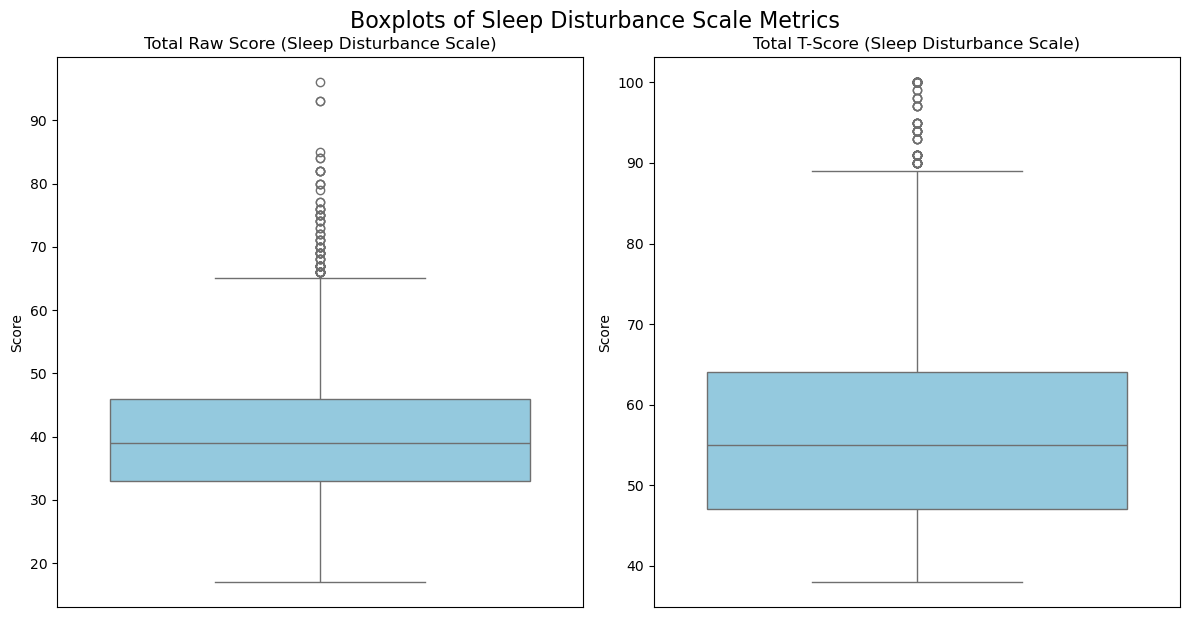

In [14]:
# List of Sleep Disturbance Scale variables
sleep_cols = [
    'SDS-SDS_Total_Raw',
    'SDS-SDS_Total_T'
]

# Define more descriptive titles
titles = {
    'SDS-SDS_Total_Raw': 'Total Raw Score (Sleep Disturbance Scale)',
    'SDS-SDS_Total_T': 'Total T-Score (Sleep Disturbance Scale)'
}

# Set up the grid layout for boxplots
fig, axes = plt.subplots(1, len(sleep_cols), figsize=(12, 6))  # One row for all boxplots

# Plot each variable
for idx, col in enumerate(sleep_cols):
    sns.boxplot(y=train_df[col], ax=axes[idx], color='skyblue')
    axes[idx].set_title(titles[col], fontsize=12)  # Use the descriptive title
    axes[idx].set_ylabel('Score', fontsize=10)
    axes[idx].tick_params(axis='x', bottom=False, labelbottom=False)  # Hide x-axis ticks

# Adjust layout
plt.tight_layout()
plt.suptitle('Boxplots of Sleep Disturbance Scale Metrics', fontsize=16, y=1.02)
plt.show()

## Correlation Heatmap Between Continuous Variables and Target Variable sii

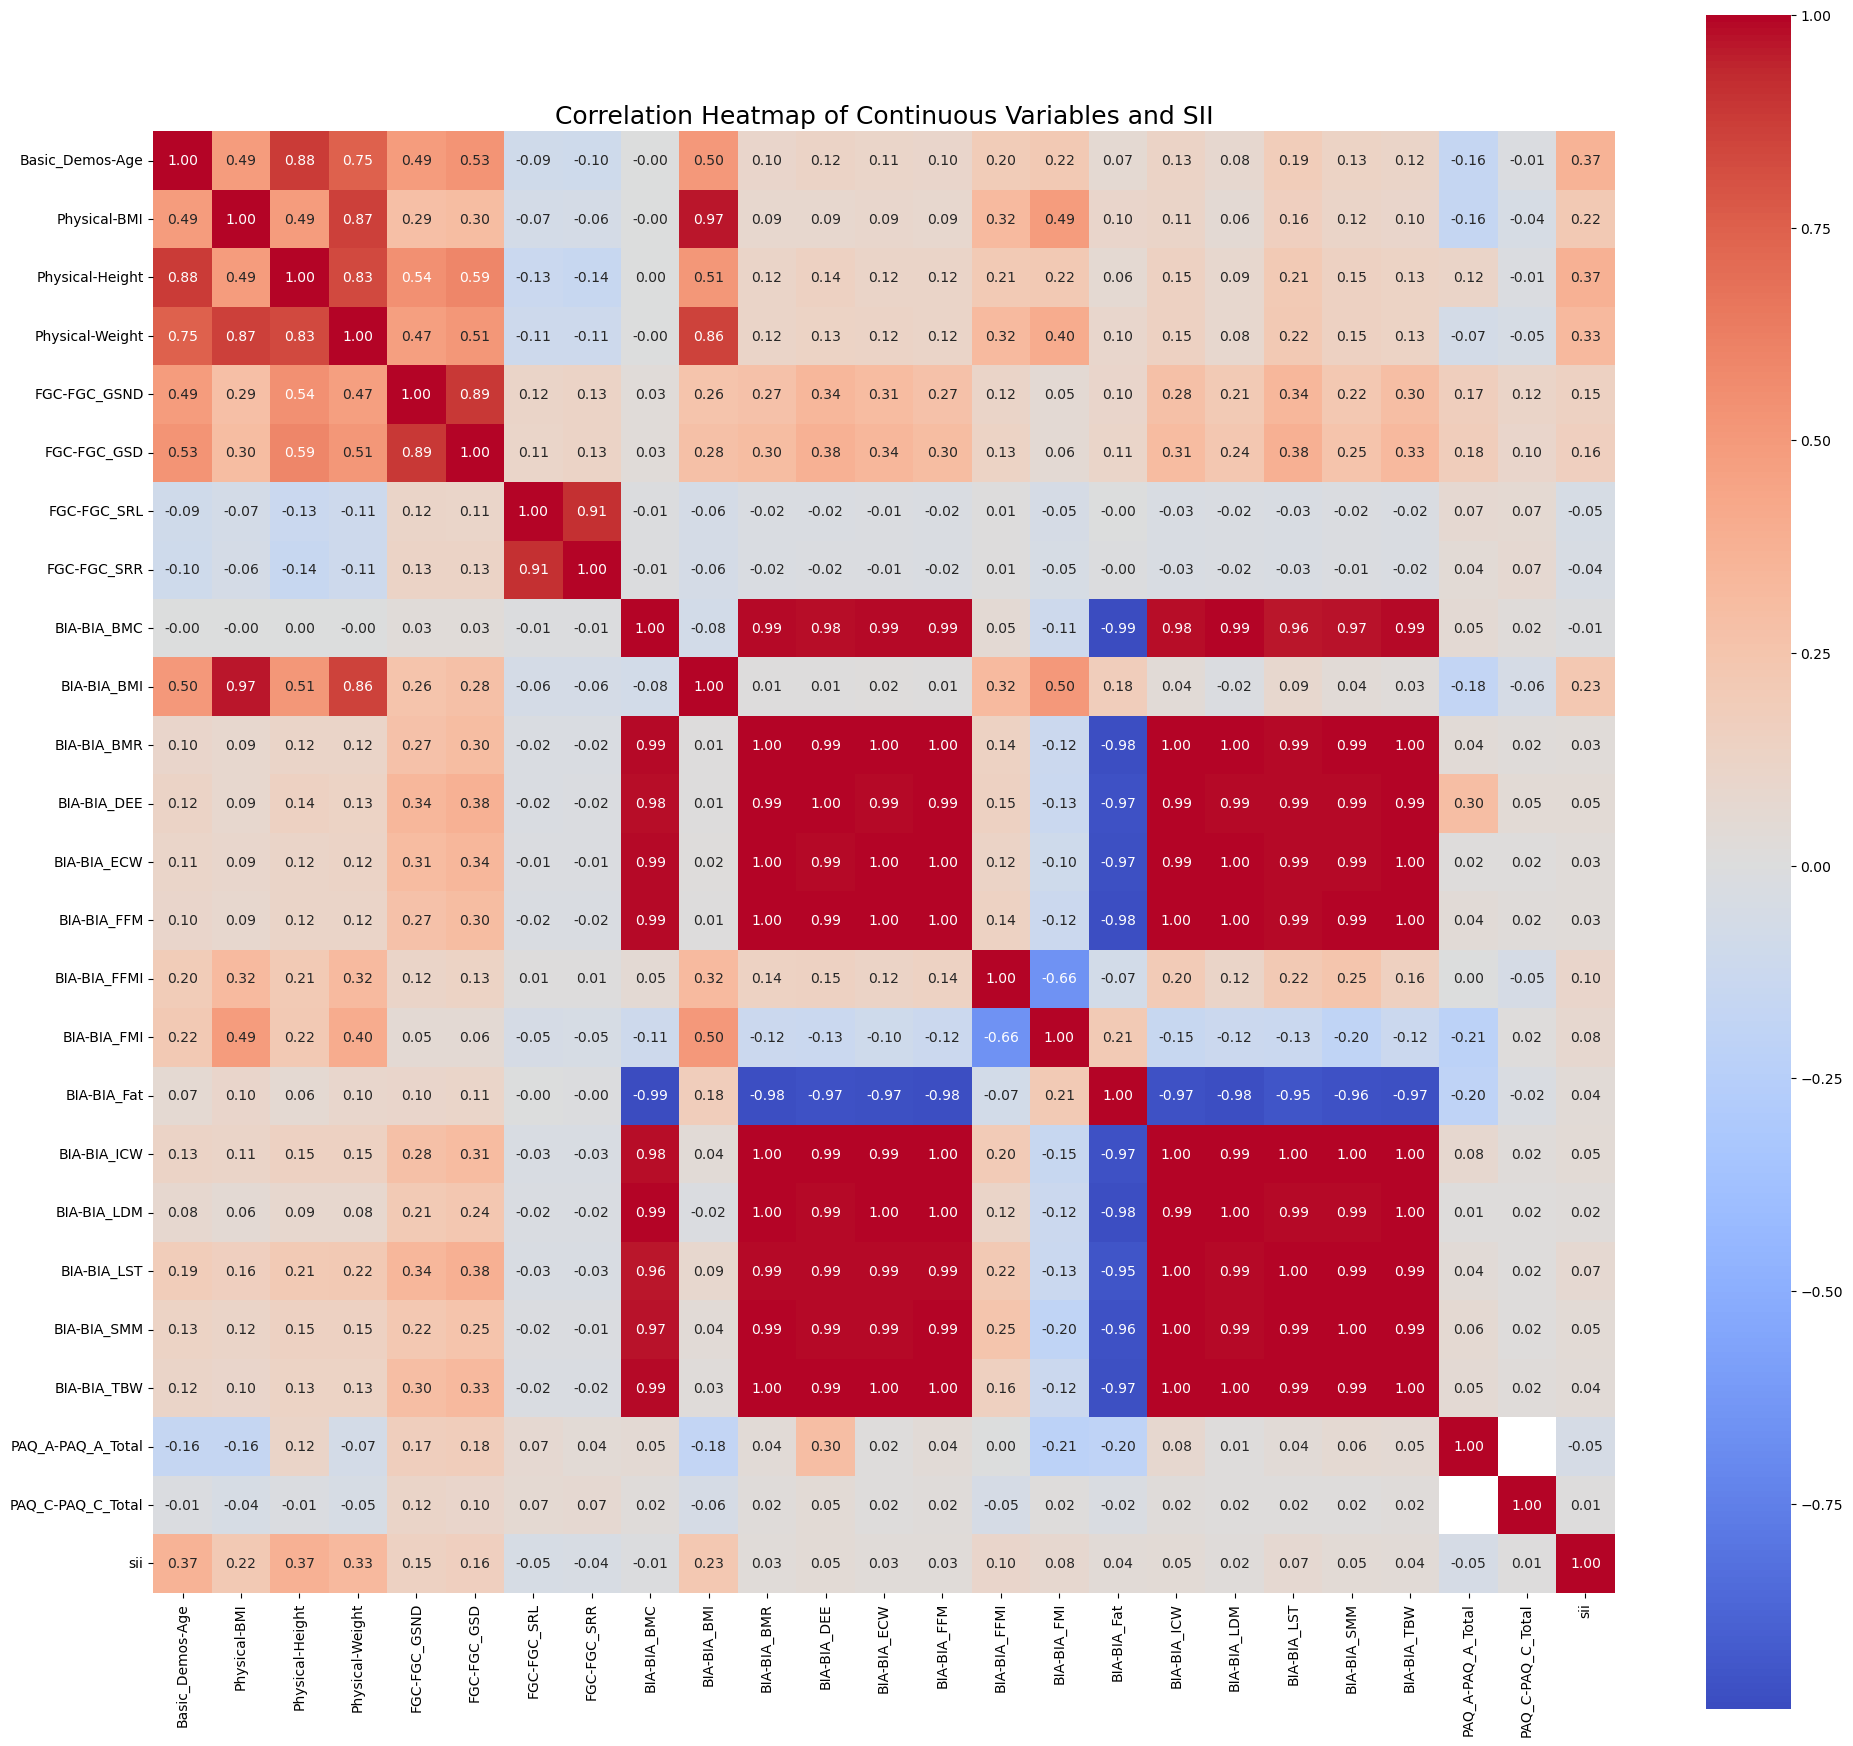

In [15]:
# Select continuous variables (numeric columns) including 'sii'
continuous_columns = [
    'Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
    'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_SRL', 'FGC-FGC_SRR',
    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE',
    'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI',
    'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
    'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'sii'
]


# Compute the full correlation matrix
correlation_matrix = train_df[continuous_columns].corr()

# Plot the full heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    square=True
)
plt.title("Correlation Heatmap of Continuous Variables and SII", fontsize=18)
plt.tight_layout()
plt.show()

# Preprocessing

## Load Data

In [16]:
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

In [17]:
train_df.shape

(3960, 82)

In [18]:
test_df.shape

(20, 59)

In [19]:
print("Columns in train_df:", train_df.columns.tolist())
print("Columns in test_df:", test_df.columns.tolist())

Columns in train_df: ['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-

## Drop Unrelated Columns

In [20]:
# Identify columns in train_df that are not in test_df but retain 'sii'
columns_to_keep = [col for col in train_df.columns if col in test_df.columns or col == 'sii']

# Filter train_df to only include these columns
train_df = train_df[columns_to_keep]

# Verify the alignment
print(f"Remaining columns in train_df: {train_df.columns.tolist()}")
print(f"Columns in test_df: {test_df.columns.tolist()}")
print(train_df.shape)
print(test_df.shape)

Remaining columns in train_df: ['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total

In [21]:
# Identify season columns in train_df (case-insensitive)
season_columns = [col for col in train_df.columns if 'season' in col.lower()]
unrelated_columns = ['id'] + season_columns

# Drop season columns from train_df
train_df = train_df.drop(columns=unrelated_columns)
print(train_df.shape)
print(test_df.shape)

(3960, 49)
(20, 59)


## Handle Missing Value

In [22]:
# Drop rows where the target 'sii' is missing
train_df = train_df.dropna(subset=['sii'])

# Split data into features (X) and target (y)
X = train_df.drop(columns=['sii'])
y = train_df['sii']

# Split into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2188, 48)
Validation data shape: (548, 48)


In [23]:
# Filter columns with type "categorical int"
categorical_int_cols = data_dictionary[data_dictionary['Type'] == 'categorical int']['Field'].tolist()
categorical_int_cols

['Basic_Demos-Sex',
 'FGC-FGC_CU_Zone',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD_Zone',
 'FGC-FGC_PU_Zone',
 'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_TL_Zone',
 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_Frame_num',
 'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PreInt_EduHx-computerinternet_hoursday']

In [24]:
# Define categorical and numerical columns dynamically
categorical_cols = [col for col in categorical_int_cols if col in X_train.columns]  # Ensure column exists
numerical_cols = [col for col in X_train.columns if col not in categorical_cols + ['sii']]  # Exclude target

print(f"Final Categorical Columns: {categorical_cols}")
print(f"Final Numerical Columns: {numerical_cols}")

# Handle missing values for numerical columns
for col in numerical_cols:
    train_mean = X_train[col].mean()
    X_train[col] = X_train[col].fillna(train_mean)  # Fill missing values with mean in train
    X_val[col] = X_val[col].fillna(train_mean)      # Use train's mean for validation

# Handle missing values for categorical columns
for col in categorical_cols:
    if col in X_train.columns:  # Check if column exists
        if X_train[col].notnull().sum() > 0:  # Ensure there are valid values to compute mode
            train_mode = X_train[col].mode()[0]
            X_train[col] = X_train[col].fillna(train_mode)  # Fill missing values with mode in train
            X_val[col] = X_val[col].fillna(train_mode)      # Use train's mode for validation
        else:
            # Handle entirely missing categorical columns
            X_train[col] = X_train[col].fillna('Unknown')
            X_val[col] = X_val[col].fillna('Unknown')

# Verify remaining missing values
print(f"Remaining missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Remaining missing values in X_val: {X_val.isnull().sum().sum()}")

Final Categorical Columns: ['Basic_Demos-Sex', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday']
Final Numerical Columns: ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']
Remaining mis

## Apply PCA to Reduce Dimensionality

### Scale the Data

In [25]:
# Initialize the scaler and scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_val_scaled = scaler.transform(X_val[numerical_cols])

### Apply PCA

In [26]:
# Initialize PCA and fit to the scaled training data
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Print the number of components retained
print(f"Number of components retained: {pca.n_components_}")

Number of components retained: 18


In [27]:
# Convert PCA components back to DataFrame for better interpretability
pca_columns = [f"PC{i+1}" for i in range(pca.n_components_)]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
X_val_pca_df = pd.DataFrame(X_val_pca, columns=pca_columns)

print("PCA-Transformed Training Data:")
print(X_train_pca_df.head())

PCA-Transformed Training Data:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.954582 -0.550857 -0.641971  1.653788 -1.431214  3.679263  3.334569   
1 -0.417587 -0.704001 -0.379699  1.346185  1.075365 -0.165323  0.293658   
2 -2.894577 -2.209806  3.018470  0.055063 -1.414378 -0.082564 -0.653093   
3 -0.297757 -0.527287 -0.252899  1.630063  1.676703 -0.492433  0.457188   
4  0.488421  0.994879  0.323295 -0.052186 -0.107134  0.586402  2.223502   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.220448  0.249406 -0.868509  0.608173  0.231302  0.069854  1.154387   
1  0.219127  0.037266 -0.186705  0.525544  0.219128  0.166981  0.332075   
2 -1.134555 -0.548306  1.102714  0.183500  0.105229 -1.155125 -1.302079   
3 -0.220960 -0.107449  0.193653  0.430715  0.258057 -0.166785  0.122184   
4 -1.100756  2.684331 -0.412747  1.720045  0.513314 -0.494033 -0.095450   

       PC15      PC16      PC17      PC18  
0  1.099167  0.408454 -

### Interpret PCA Components

In [28]:
# Create a DataFrame of PCA loadings
loadings_df = pd.DataFrame(
    pca.components_, 
    columns=numerical_cols,  # Original feature names
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Display the top contributing features for each principal component
print("PCA Loadings (Top 5 Features per Component):")
for pc in loadings_df.index:
    print(f"\n{pc} (Top Features):")
    print(loadings_df.loc[pc].abs().sort_values(ascending=False).head(5))

PCA Loadings (Top 5 Features per Component):

PC1 (Top Features):
BIA-BIA_FFM    0.287916
BIA-BIA_BMR    0.287916
BIA-BIA_TBW    0.287455
BIA-BIA_ICW    0.284054
BIA-BIA_LST    0.283312
Name: PC1, dtype: float64

PC2 (Top Features):
BIA-BIA_Fat        0.407363
BIA-BIA_FMI        0.387766
Physical-Weight    0.323574
Physical-BMI       0.297001
BIA-BIA_BMI        0.286047
Name: PC2, dtype: float64

PC3 (Top Features):
FGC-FGC_PU                     0.377041
FGC-FGC_CU                     0.330216
Fitness_Endurance-Time_Mins    0.306864
Fitness_Endurance-Max_Stage    0.301468
FGC-FGC_SRR                    0.289768
Name: PC3, dtype: float64

PC4 (Top Features):
SDS-SDS_Total_Raw    0.469133
SDS-SDS_Total_T      0.467541
FGC-FGC_SRR          0.414449
FGC-FGC_SRL          0.411544
FGC-FGC_GSND         0.180449
Name: PC4, dtype: float64

PC5 (Top Features):
SDS-SDS_Total_T                0.473838
SDS-SDS_Total_Raw              0.470969
Fitness_Endurance-Time_Mins    0.382085
Fitness_Enduranc

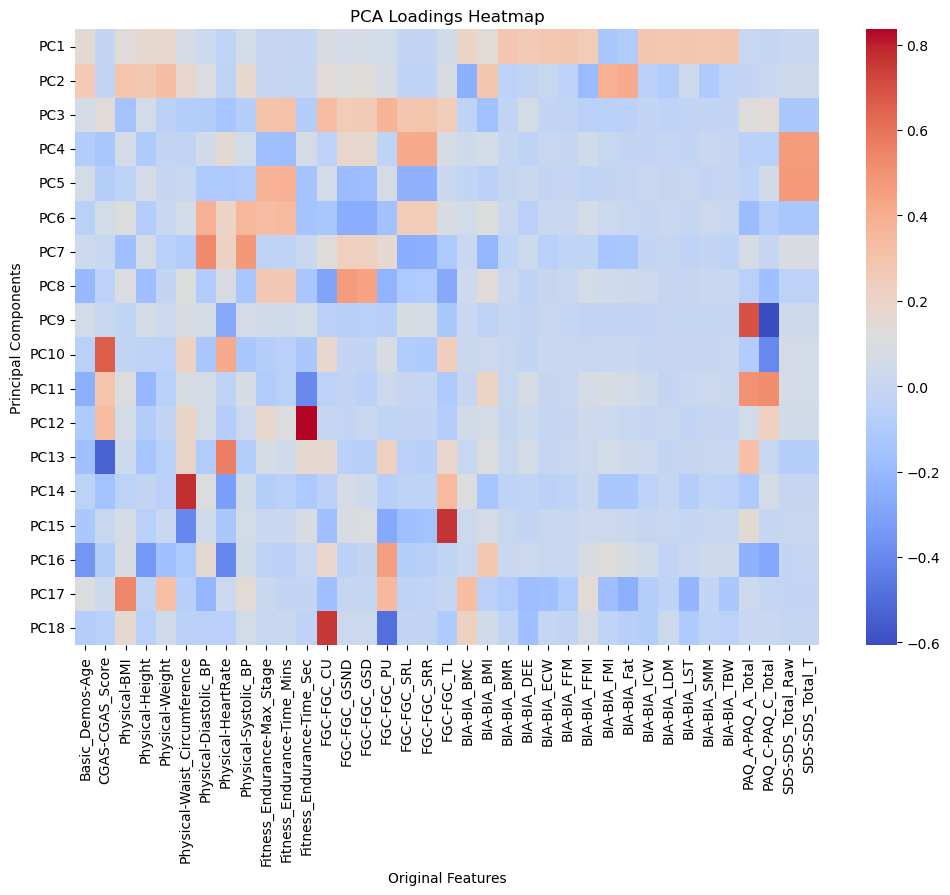

In [29]:
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, cmap="coolwarm", annot=False, cbar=True)
plt.title("PCA Loadings Heatmap")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.show()

## Make Final Train

In [30]:
X_train = pd.concat([X_train_pca_df, X_train[categorical_cols].reset_index(drop=True)], axis=1)
X_val = pd.concat([X_val_pca_df, X_val[categorical_cols].reset_index(drop=True)], axis=1)

print("Final Training Dataset After PCA:")
print(X_train.head())

Final Training Dataset After PCA:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.954582 -0.550857 -0.641971  1.653788 -1.431214  3.679263  3.334569   
1 -0.417587 -0.704001 -0.379699  1.346185  1.075365 -0.165323  0.293658   
2 -2.894577 -2.209806  3.018470  0.055063 -1.414378 -0.082564 -0.653093   
3 -0.297757 -0.527287 -0.252899  1.630063  1.676703 -0.492433  0.457188   
4  0.488421  0.994879  0.323295 -0.052186 -0.107134  0.586402  2.223502   

        PC8       PC9      PC10  ...  FGC-FGC_CU_Zone  FGC-FGC_GSND_Zone  \
0 -0.220448  0.249406 -0.868509  ...              1.0                2.0   
1  0.219127  0.037266 -0.186705  ...              1.0                2.0   
2 -1.134555 -0.548306  1.102714  ...              1.0                2.0   
3 -0.220960 -0.107449  0.193653  ...              1.0                2.0   
4 -1.100756  2.684331 -0.412747  ...              1.0                2.0   

   FGC-FGC_GSD_Zone  FGC-FGC_PU_Zone  FGC-FGC_SRL_Zone  FG

### Machine Learning

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

print(f"Train score:", lr.score(X_train, y_train))
print(f"Test score:", lr.score(X_val, y_val))

y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)

train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)


print(f"Train MSE: {train_mse}")
print(f"Test MSE: {val_mse}")

Train score: 0.23687886725543683
Test score: 0.10214723598202868
Train MSE: 0.4506710681094039
Test MSE: 0.5465258333269922


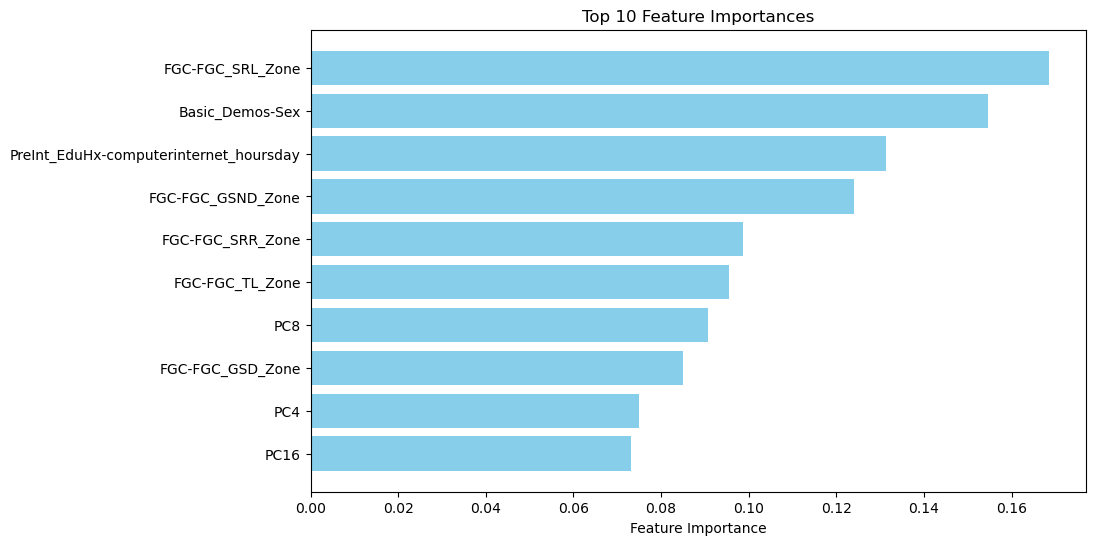

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming the linear regression model is already fitted
coefficients = lr.coef_

# Create a DataFrame to store feature names and their corresponding importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(coefficients)
})

# Sort the DataFrame by importance in descending order and select the top 10 features
top_10_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


In [33]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

depth = 21
depthvalues = [i for i in range(1, depth)]
leaf = 10
leafvalues = [i for i in range(1, leaf)]

relative_best_train_score = float('inf')
relative_best_test_score = float('inf')
relative_best_train_accuracy = -float('inf')
relative_best_test_accuracy = -float('inf')
relative_best_depth = 0
relative_best_leaf = 0
relative_best_train = []
relative_best_test = []

for i in depthvalues:
    for j in leafvalues:
        clf = RandomForestClassifier(random_state=71, n_estimators=100, max_depth=i, min_samples_leaf=j)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_val)

        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_val, y_pred_test)

        # Using accuracy to determine the best model
        if test_accuracy > relative_best_test_accuracy:
            relative_best_train_accuracy = train_accuracy
            relative_best_test_accuracy = test_accuracy
            relative_best_depth = i
            relative_best_leaf = j
            relative_best_train = y_train, y_pred_train
            relative_best_test = y_val, y_pred_test

print("Best depth:", relative_best_depth, "Best min_samples_leaf:", relative_best_leaf, 
      "\nTraining Accuracy:", relative_best_train_accuracy, "Testing Accuracy:", relative_best_test_accuracy)


Best depth: 17 Best min_samples_leaf: 7 
Training Accuracy: 0.8158135283363802 Testing Accuracy: 0.6295620437956204


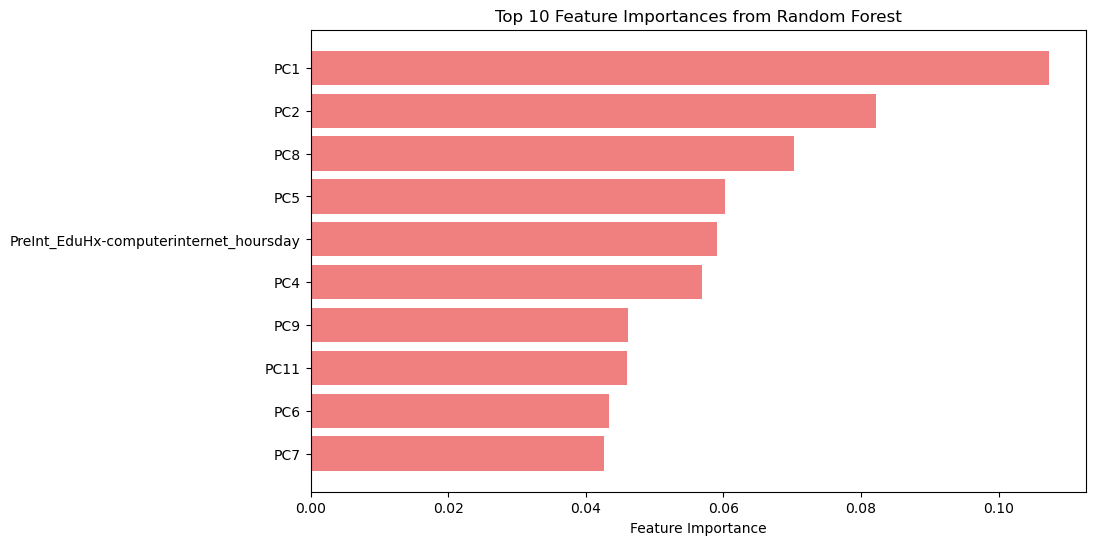

In [34]:
best_clf = RandomForestClassifier(
    random_state=71, 
    n_estimators=100, 
    max_depth=relative_best_depth, 
    min_samples_leaf=relative_best_leaf
)
best_clf.fit(X_train, y_train)


feature_importance = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': best_clf.feature_importances_
})

top_10_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)


plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='lightcoral')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances from Random Forest')
plt.gca().invert_yaxis() 
plt.show()

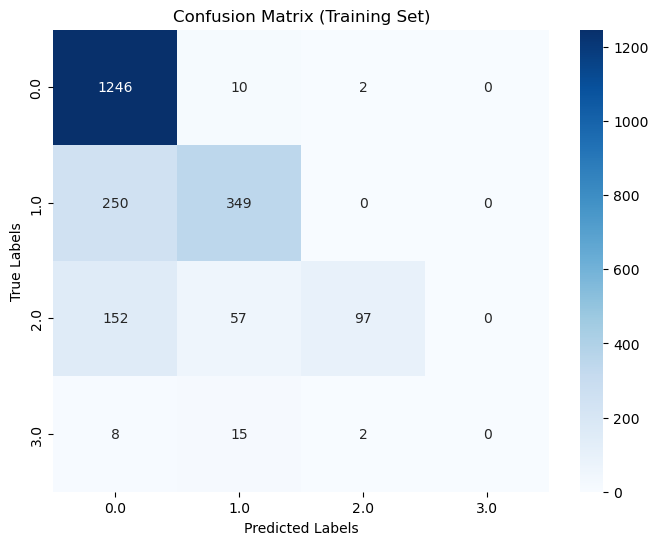

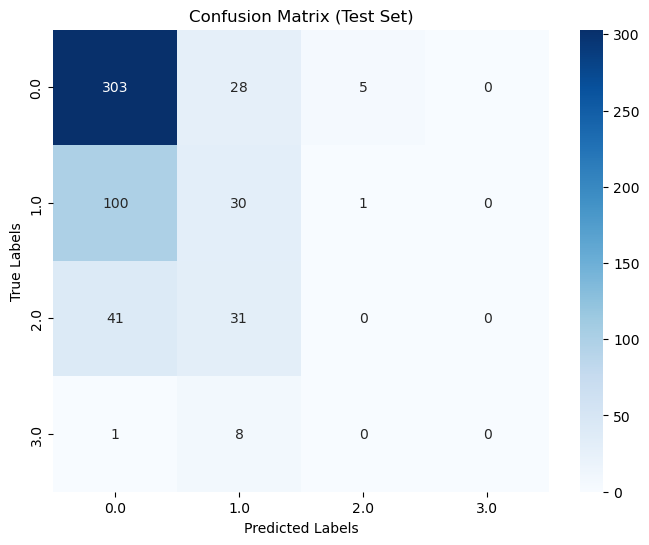

In [35]:
# Confusion Matrix for Training Set
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix (Training Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Confusion Matrix for Test Set
conf_matrix_test = confusion_matrix(y_val, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [36]:
# XGBoost
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score

ratio = 100
ratiovalues = [i for i in range(10, ratio, 10)]
n_estimator = 250
n_estimatorvalues = [i for i in range(100, n_estimator, 50)]
depth = 8
depthvalues = [i for i in range(1, depth)]
rate = 3
ratevalues = [i for i in range(1, rate)]
relative_best_train_score = 0
relative_best_test_score = 0
relative_best_ratio = 0
relative_best_estimators = 0
relative_best_depth = 0
relative_best_rate = 0

for l in n_estimatorvalues:
    for i in depthvalues:
        for j in ratevalues:
            clf = XGBClassifier(random_state = 71, n_estimators = l, max_depth = i, learning_rate = j)
            clf.fit(X_train, y_train)
            y_pred_train = clf.predict(X_train) #train
            train_acc = accuracy_score(y_pred_train, y_train)
            y_pred_test = clf.predict(X_val) #train
            test_acc = accuracy_score(y_pred_test, y_val)

            if ((train_acc > relative_best_train_score) and (test_acc > relative_best_test_score)):
                relative_best_train_score = train_acc
                relative_best_test_score = test_acc
                relative_best_estimators = l
                relative_best_depth = i
                relative_best_rate = j

print("best no. of estimators:", relative_best_estimators, "best depth:", relative_best_depth, "best learning_rate:", relative_best_rate, \
      "\nTraining score:", relative_best_train_score, "Testing score:", relative_best_test_score)

best no. of estimators: 100 best depth: 1 best learning_rate: 2 
Training score: 0.7312614259597806 Testing score: 0.6204379562043796


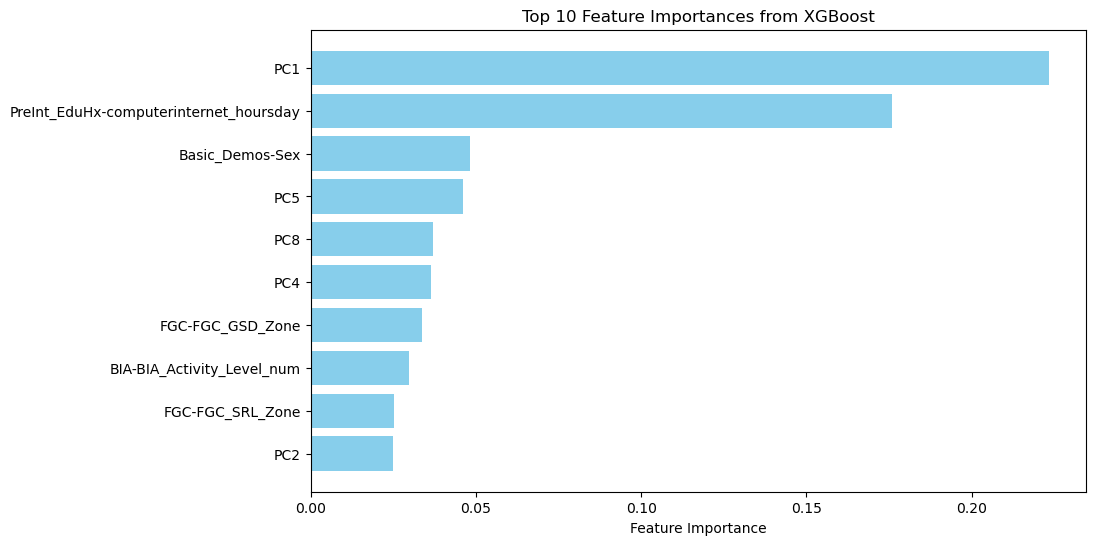

In [37]:
best_clf = XGBClassifier(
    random_state=71, 
    n_estimators=relative_best_estimators, 
    max_depth=relative_best_depth, 
    learning_rate=relative_best_rate
)
best_clf.fit(X_train, y_train)


feature_importance = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': best_clf.feature_importances_
})

# top ten features
top_10_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)


plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances from XGBoost')
plt.gca().invert_yaxis()  
plt.show()

In [38]:
# Neutral Networks
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


parameters = {
    'hidden_layer_sizes': [(30,), (60,), (80,)],  
    'activation': ['logistic', 'tanh', 'relu'],  
    'solver': ['sgd', 'adam'], 
    'learning_rate': ['constant', 'adaptive'],  
    'max_iter': [1000, 2000] 
}


gs = GridSearchCV(MLPClassifier(early_stopping=True), param_grid=parameters, cv=5)
gs.fit(X_train_scaled, y_train)


print("Best Score:", gs.best_score_)
print("Best Parameters:", gs.best_params_)


Best Score: 0.6051252311839754
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (80,), 'learning_rate': 'constant', 'max_iter': 2000, 'solver': 'adam'}


In [39]:
from sklearn.inspection import permutation_importance

# Perform GridSearch and fit the best model
best_model = gs.best_estimator_

# Compute permutation feature importance
perm_importance = permutation_importance(best_model, X_val_scaled, y_val, n_repeats=10, random_state=42)

# Extract and sort feature importances
sorted_idx = perm_importance.importances_mean.argsort()[-10:][::-1]  # Top 10 features
for i in sorted_idx:
    print(f"Feature {i}: Importance = {perm_importance.importances_mean[i]}")


Feature 28: Importance = 0.018978102189780955
Feature 4: Importance = 0.013503649635036464
Feature 1: Importance = 0.011678832116788274
Feature 18: Importance = 0.010948905109488982
Feature 15: Importance = 0.007664233576642287
Feature 10: Importance = 0.006751824817518182
Feature 3: Importance = 0.006021897810218923
Feature 20: Importance = 0.00510948905109484
Feature 25: Importance = 0.0045620437956203855
Feature 26: Importance = 0.003832116788321116


Top 10 Features by Permutation Importance:
                                   Feature  Importance
28  PreInt_EduHx-computerinternet_hoursday    0.018978
4                                      PC5    0.013504
1                                      PC2    0.011679
18                         Basic_Demos-Sex    0.010949
15                                    PC16    0.007664
10                                    PC11    0.006752
3                                      PC4    0.006022
20                       FGC-FGC_GSND_Zone    0.005109
25                         FGC-FGC_TL_Zone    0.004562
26              BIA-BIA_Activity_Level_num    0.003832


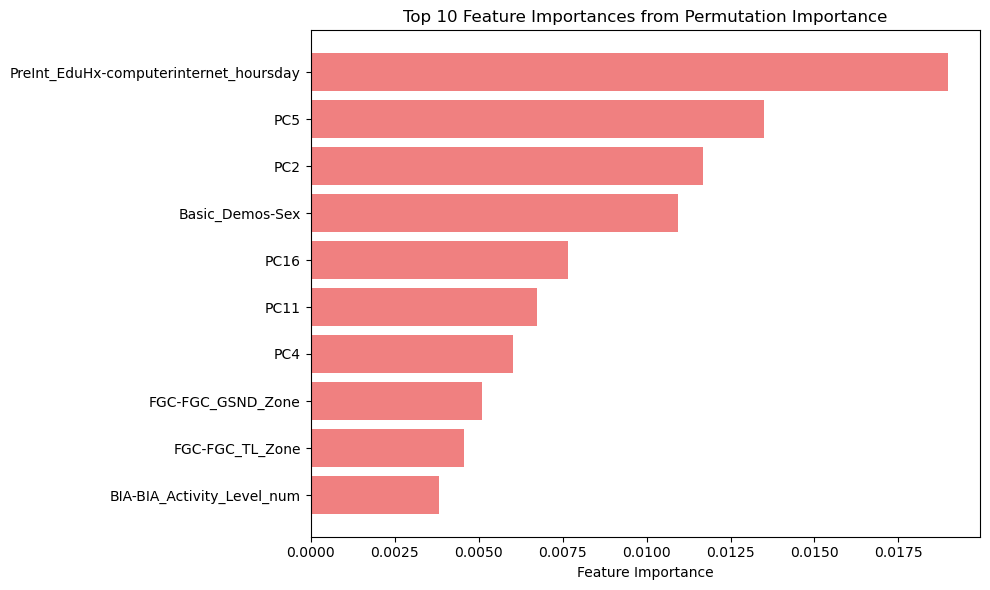

In [40]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Perform GridSearch and fit the best model
best_model = gs.best_estimator_

# Compute permutation feature importance
perm_importance = permutation_importance(best_model, X_val_scaled, y_val, n_repeats=10, random_state=42)

# Handle feature names (replace feature_names with your actual feature list)
if isinstance(X_val_scaled, np.ndarray):
    feature_names = X_train.columns  # Replace with actual feature names from X_train
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_names)

# Create DataFrame for feature importances
feature_importance = pd.DataFrame({
    'Feature': [feature_names[i] for i in range(len(feature_names))],  # Map indices to actual feature names
    'Importance': perm_importance.importances_mean
})

# Sort and get top 10 features
top_10_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)

# Print top 10 features with their importance
print("Top 10 Features by Permutation Importance:")
print(top_10_features)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='lightcoral')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances from Permutation Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.tight_layout()
plt.show()